### Import Modules

In [1]:
import json
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2" 
import time
import socket
from pathlib import Path
import cv2
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import faiss
res = faiss.StandardGpuResources()
KNN_index = faiss.GpuIndexFlatL2(res, 256)
from torch.utils.tensorboard import SummaryWriter
from torch.distributions import MultivariateNormal
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pixel_generator.mage import models_mage
from PIL import Image
from imagenet_clstolabel import IMGNET_CLASS2LABEL
from IPython.display import display

/root/miniconda3/envs/rcg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### viz function

In [2]:
def viz_torchimage(image):
    image = torch.clamp(image, 0, 1)
    image_np = image.detach().cpu().numpy().transpose([1, 2, 0])
    image_np = Image.fromarray(np.uint8(image_np*255))
    display(image_np)

## Base version inference

In [3]:
# Initialize RCG-B
class_cond = False
if class_cond:
    rdm_ckpt_path = 'final_ckpts/rdm-mocov3vitb-clscond.pth'
    rdm_cfg = 'config/rdm/mocov3vitb_simplemlp_l12_w1536_classcond.yaml'
else:
    rdm_ckpt_path = 'final_ckpts/rdm-mocov3vitb.pth'
    rdm_cfg = 'config/rdm/mocov3vitb_simplemlp_l12_w1536.yaml'
model = models_mage.mage_vit_base_patch16(mask_ratio_mu=0.75, mask_ratio_std=0.25,
                                           mask_ratio_min=0.5, mask_ratio_max=1.0,
                                           vqgan_ckpt_path='vqgan-ckpts/vqgan_jax_strongaug.ckpt',
                                           use_rep=True, rep_dim=256, rep_drop_prob=0.1,
                                           use_class_label=False,
                                           pretrained_enc_arch='mocov3_vit_base',
                                           pretrained_enc_path='pretrained_enc_ckpts/mocov3/vitb.pth.tar',
                                           pretrained_enc_proj_dim=256,
                                           pretrained_enc_withproj=True,
                                           pretrained_rdm_ckpt=rdm_ckpt_path,
                                           pretrained_rdm_cfg=rdm_cfg)
checkpoint = torch.load(os.path.join('final_ckpts/mage-b.pth'), map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=True)
model.cuda()
_ = model.eval()

Use representation as condition!
Loading model from final_ckpts/rdm-mocov3vitb.pth
RDM: Running in x0-prediction mode
DiffusionWrapper has 62.72 M params.
Keeping EMAs of 132.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Strict load
Restored from vqgan-ckpts/vqgan_jax_strongaug.ckpt


### 2. Image Generation

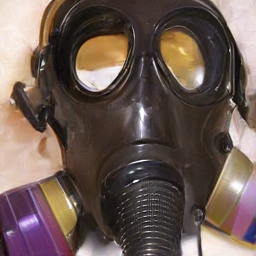

In [7]:
torch.manual_seed(7)
np.random.seed(7)

n_image_to_gen = 1
rdm_steps = 250
rdm_eta = 1.0
mage_temp = 11.0
mage_steps = 20
cfg = 6.0
if class_cond:
    for class_label in [1, 323, 985]:
        print("{}: {}".format(class_label, IMGNET_CLASS2LABEL[class_label]))
        class_label = class_label * torch.ones(1).cuda().long()
        for i in range(n_image_to_gen):
            gen_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=None, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=class_label)
            viz_torchimage(gen_images[0])

else:
    for i in range(n_image_to_gen):
        gen_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=None, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=None)
        viz_torchimage(gen_images[0])

## GT Representation Reconstruction

### Initialize data loader


In [4]:
# get train loader
torch.manual_seed(0)
np.random.seed(0)
bsz = 1
transform = transforms.Compose([
            transforms.Resize(256, interpolation=3),
            transforms.CenterCrop(256),
            transforms.ToTensor()])

dataset = datasets.ImageFolder('/root/datasets/imagenet1k_train', transform=transform)
print('num_data:', len(dataset))
print('num_classes:', len(dataset.classes))
data_loader = torch.utils.data.DataLoader(
        dataset,
        shuffle=True,
        batch_size=bsz,
        num_workers=10,
        pin_memory=True,
        drop_last=True,
)
data_iterator = enumerate(data_loader)

num_data: 2600
num_classes: 2


### Generate Image from GT Representation

Ground Truth Image:


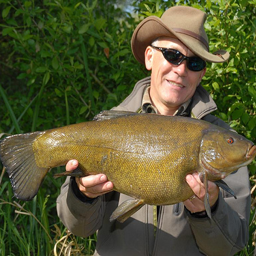

Reconstructed Images:


/root/miniconda3/envs/rcg/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


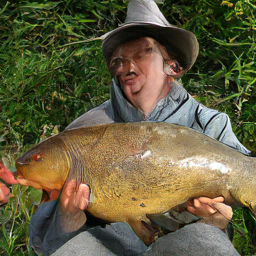

In [5]:
n_image_to_gen = 1
rdm_steps = 250
rdm_eta = 1.0
mage_temp = 11.0
mage_steps = 20
cfg = 6.0

_, (images, _) = next(data_iterator)  # (iter_num, img, label)

images = images.cuda()
print("Ground Truth Image:")
viz_torchimage(images[0])

# get rep
with torch.no_grad():
    mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    std = torch.Tensor([0.229, 0.224, 0.225]).cuda().unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    x_normalized = (images - mean) / std
    x_normalized = torch.nn.functional.interpolate(x_normalized, 224, mode='bicubic')
    rep = model.pretrained_encoder.forward_features(x_normalized)
    if model.pretrained_enc_withproj:
        rep = model.pretrained_encoder.head(rep)
    rep_std = torch.std(rep, dim=1, keepdim=True)
    rep_mean = torch.mean(rep, dim=1, keepdim=True)
    rep = (rep - rep_mean) / rep_std

print("Reconstructed Images:")
recon_image_list = []
for _ in range(n_image_to_gen):
    recon_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=rep, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=None)
    viz_torchimage(recon_images[0])


### ※get ano rep

1. direct add noise

Add Noise Images:


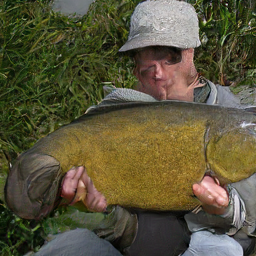

In [13]:
std = 0.01
rand_noise = torch.randn(rep.shape).cuda()
rep_noisy = rep + rand_noise * std

print("Add Noise Images:")
recon_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=rep_noisy, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=None)
viz_torchimage(recon_images[0])

2. dream-ood

In [ ]:
def KNN_dis_search_decrease(target, index, K=50, select=1,shift=0):
    '''
    data_point: Queue for searching k-th points
    target: the target of the search
    K
    '''
    #Normalize the features

    target_norm = torch.norm(target, p=2, dim=1,  keepdim=True)
    normed_target = target / target_norm
    #start_time = time.time()

    distance, output_index = index.search(normed_target, K)
    k_th_distance = distance[:, -1]
    #k_th_output_index = output_index[:, -1]
    if shift:
        k_th_distance, minD_idx = torch.topk(-k_th_distance, select)
    else:
        k_th_distance, minD_idx = torch.topk(k_th_distance, select)
    #k_th_index = k_th_output_index[minD_idx]
    return minD_idx, k_th_distance


def generate_outliers(ID, input_index, negative_samples, ID_points_num=2,
                      K=20, select=1, cov_mat=0.1, sampling_ratio=1.0,
                      pic_nums=30, depth=342, shift=0):
    # 1. num of negativce samples
    length = negative_samples.shape[0]
    # 2. norm ID data
    data_norm = torch.norm(ID, p=2, dim=1, keepdim=True)
    normed_data = ID / data_norm
    # 3. init KNN index
    index = input_index
    # 4. random pick ID sample, add to index
    rand_ind = np.random.choice(normed_data.shape[0], int(normed_data.shape[0] * sampling_ratio), replace=False)
    index.add(normed_data[rand_ind])
    # 5. KNN search, get 200(select) boundary ID sample
    minD_idx, k_th = KNN_dis_search_decrease(ID, index, K, select, shift=shift)
    boundary_data = ID[minD_idx]
    # 6. random pick 50(pic_nums) boundary_idx
    minD_idx = minD_idx[np.random.choice(select, int(pic_nums), replace=False)]
    # 7. pick OOD sample by boundary ID sample
    data_point_list = torch.cat([ID[i:i+1].repeat(length,1) for i in minD_idx])  # [1500*50, 768]
    negative_sample_cov = cov_mat * negative_samples.cuda().repeat(pic_nums,1)  # [1500, 768].repeat(50,1) -> [1500*50, 768]
    negative_sample_list = F.normalize(negative_sample_cov + data_point_list, p=2, dim=1)
    point = KNN_dis_search_distance(negative_sample_list, index, K, ID_points_num, length, depth, shift=shift)
    index.reset()
    return point, boundary_data

# -------------------------------- 1. load ID -------------------------------- #
data_rep = np.load('outputs/rep_class_1.npy')
data_rep = torch.tensor(data_rep).cuda()
ID = F.normalize(data_rep, p=2, dim=1)

new_dis = MultivariateNormal(torch.zeros(256).cuda(), torch.eye(256).cuda())
negative_samples = new_dis.rsample((1500,))
sample_point1, boundary_point = generate_outliers(ID,
                                                input_index=KNN_index,
                                                negative_samples=negative_samples,
                                                ID_points_num=1,
                                                K=300,
                                                select=200,
                                                cov_mat=0.03,
                                                sampling_ratio=1.0,
                                                pic_nums=50,
                                                depth=768, shift=0)

# ------------------------------ 2. generate img ----------------------------- #
rdm_steps = 250
rdm_eta = 1.0
mage_temp = 11.0
mage_steps = 20
cfg = 6.0

print("Dream OOD Images:")
recon_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=sample_point1, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=None)
viz_torchimage(recon_images[0])

3. RDM ano guidance

4. RDM known rep intp

5. RDM class-cond rep intp